a remote control: 0.3264574110507965 [332.1690368652344, 74.36456298828125, 370.24322509765625, 187.7555694580078]
a remote control: 0.34898045659065247 [38.34071731567383, 70.01449584960938, 176.30352783203125, 117.32209777832031]
a cat: 0.4424400329589844 [342.70562744140625, 22.10198974609375, 636.21044921875, 376.49615478515625]
a cat: 0.4128117561340332 [9.538326263427734, 50.840763092041016, 317.4217834472656, 472.48516845703125]


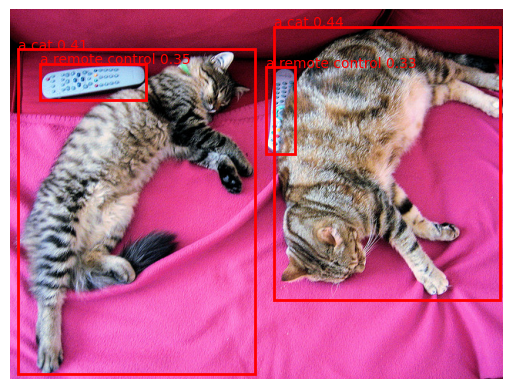

In [25]:
import requests

import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 
import math

model_id = "IDEA-Research/grounding-dino-base"
def get_device():
    devstr = "cpu"
    if torch.cuda.is_available():
        devstr = "cuda"
    elif torch.backends.mps.is_available():
        devstr = "mps"
    return devstr
device = get_device()

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

text = "a cat. a remote control." # VERY important: text queries need to be lowercased + end with a dot

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.3,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)[0]

plt.imshow(image)
for res in list(zip(results["labels"], results["scores"], results["boxes"])):
    label = res[0]
    score = res[1].item()
    box = res[2].tolist()
    print(f"{label}: {score} {box}")
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor="red", lw=2))
    plt.text(box[0], box[1], f"{label} {score:.2f}", color="red")
plt.axis("off")
plt.show()
